In [1]:
import mdtraj as md
from ase import Atoms
import nglview as nv
import networkx as nx

import torch
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, SAGPooling, InnerProductDecoder
import torch_geometric.data as data
from torch_geometric.utils.convert import to_networkx

import numpy as np
import matplotlib.pyplot as plt


In [2]:
all_frames = md.load_xtc("../simulation/npt.xtc", top="../simulation/box.gro")


In [3]:
all_frames_fatures = []

for i in range(all_frames.xyz.shape[0]):
    mol_com_pos = []

    for res in all_frames.top.residues:
        # print(res.index,end=" ")
        pos = []
        for atom in res.atoms:
            # print(atom.index,"-->" , frame.xyz[0][atom.index],end=" ")
            pos.append(all_frames.xyz[i][atom.index])
        mol_com_pos.append(np.mean(pos,axis=0))
        
        # print()
    mol_com_pos = np.array(mol_com_pos).astype(np.float32)  
    all_frames_fatures.append(mol_com_pos)

all_frames_fatures = np.array(all_frames_fatures).astype(np.float32)
print(all_frames_fatures.shape)

(51, 101, 3)


In [4]:
print(dir(all_frames.topology.residue(0)))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_atoms', 'atom', 'atoms', 'atoms_by_name', 'chain', 'code', 'index', 'is_nucleic', 'is_protein', 'is_water', 'n_atoms', 'name', 'resSeq', 'segment_id']


In [5]:
n_frames = all_frames.xyz.shape[0]
n_atoms = all_frames.topology.residue(0).n_atoms
n_mols = all_frames.topology.n_residues

In [6]:
print("number of molecules",n_mols)
print("number of atoms in molecule",n_atoms)
print("number of frames",n_frames)

number of molecules 101
number of atoms in molecule 4
number of frames 51


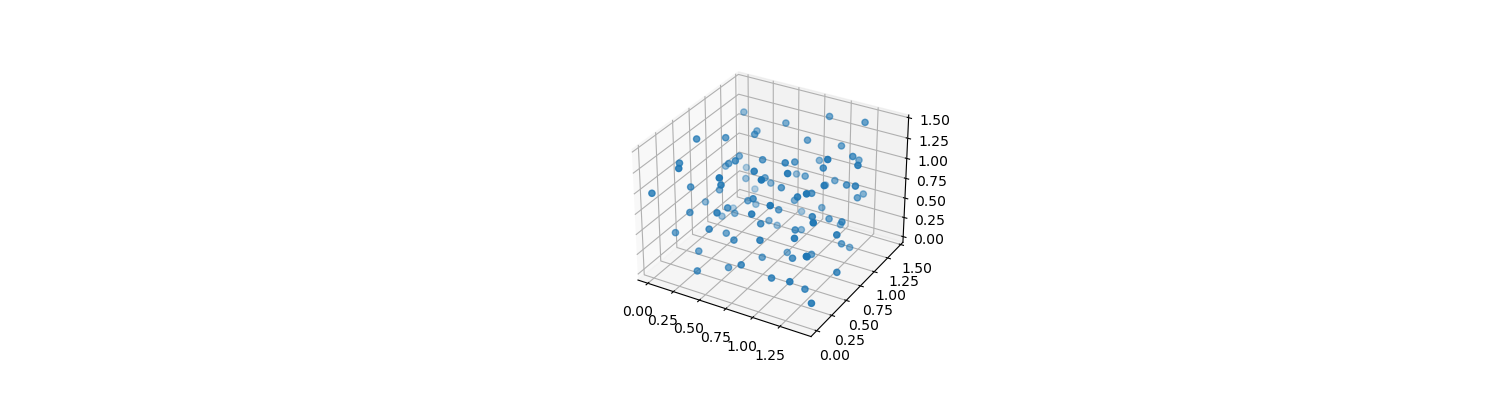

In [7]:
%matplotlib widget

frame = 10

fig = plt.figure(figsize=(15,4))
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(all_frames_fatures[frame][:,0],all_frames_fatures[frame][:,1],all_frames_fatures[frame][:,2])
plt.show()

In [8]:
def convert_to_adj(edge_index, num_nodes=None):
    if num_nodes is None:
        num_nodes = edge_index.max() + 1
    adj = torch.zeros(num_nodes, num_nodes)
    adj[edge_index[0], edge_index[1]] = 1
    return adj

def convert_to_edge_index(adj):
    edge_index = adj.nonzero().t()
    return edge_index

In [9]:
cutoff = 0.5

all_edge_list = []
all_edge_features = []
for frame_i in range(n_frames):
    from_list = []
    to_list = []
    features  = []
    for i in range(len(all_frames_fatures[frame_i])):
        for j in range(i+1,len(all_frames_fatures[frame_i])):
            if np.linalg.norm(all_frames_fatures[frame_i][i]-all_frames_fatures[frame_i][j]) < cutoff:
                # print(i,j,np.linalg.norm(mol_com_pos[i]-mol_com_pos[j]))
                from_list.append(i)
                to_list.append(j)

                to_list.append(i)
                from_list.append(j)

                features.append(np.linalg.norm(all_frames_fatures[frame_i][i]-all_frames_fatures[frame_i][j]))
                features.append(np.linalg.norm(all_frames_fatures[frame_i][i]-all_frames_fatures[frame_i][j]))

    edge_list = np.array([from_list,to_list]).astype(np.int64)
    edge_features = np.array(features).astype(np.float32)
    all_edge_list.append(edge_list)
    all_edge_features.append(edge_features)



In [10]:
print(all_edge_list[0].shape)
print(all_edge_features[0].shape)

(2, 1158)
(1158,)


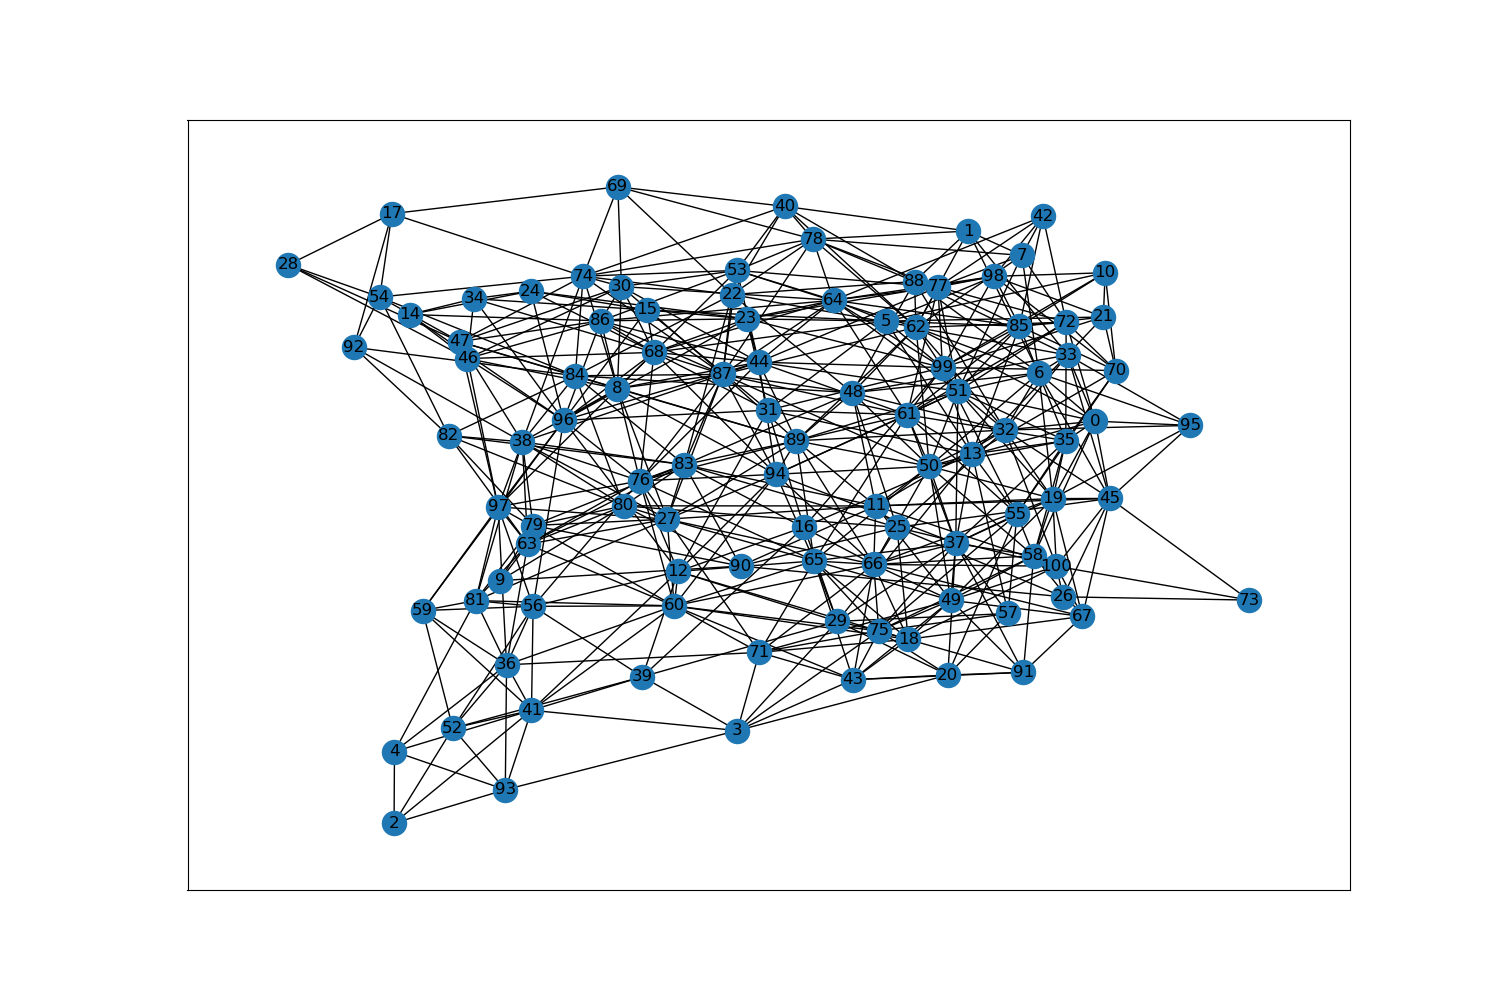

In [11]:
%matplotlib widget

frame = 10

plt.figure(figsize=(15,10))
adj_binary = convert_to_adj(all_edge_list[frame], num_nodes=101)
indices = torch.where(adj_binary)
G = nx.Graph()
edges = [(i, j) for i, j in zip(indices[0].tolist(), indices[1].tolist()) if i != j]
G.add_edges_from(edges)
nx.draw_networkx(G)


### Converting to pytorch graph object

In [12]:
graphs = []
for frame in range(n_frames):
    g = data.Data(x=torch.tensor(all_frames_fatures[frame]).float(), edge_index=torch.tensor(all_edge_list[frame]).long(), y=torch.tensor([0]), edge_attr=torch.tensor(all_edge_features[frame]).float())
    graphs.append(g)

print(graphs[0])

Data(x=[101, 3], edge_index=[2, 1158], edge_attr=[1158], y=[1])


## Model

In [13]:
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch.nn import Module

from torch_geometric.nn.inits import reset
from torch_geometric.utils import negative_sampling

EPS = 1e-15
MAX_LOGSTD = 10
edgeShape = None
featureShape = None


class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""

    def forward(self, z: Tensor, edge_index: Tensor,
                sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value

    def forward_all(self, z: Tensor, sigmoid: bool = True) -> Tensor:
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj


class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (torch.nn.Module): The encoder module.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        r"""Resets all learnable parameters of the module."""
        reset(self.encoder)
        reset(self.decoder)

    def forward(self, *args, **kwargs) -> Tensor:  # pragma: no cover
        r"""Alias for :meth:`encode`."""
        return self.encoder(*args, **kwargs)

    def encode(self, *args, **kwargs) -> Tensor:
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)

    def decode(self, *args, **kwargs) -> Tensor:
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)

    def recon_loss(self, z: Tensor, pos_edge_index: Tensor,
                   neg_edge_index: Optional[Tensor] = None) -> Tensor:
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to train against.
            neg_edge_index (torch.Tensor, optional): The negative edges to
                train against. If not given, uses negative sampling to
                calculate negative edges. (default: :obj:`None`)
        """
        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True)[0] + EPS).mean()

        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index.long(), sigmoid=True)[0] +
                              EPS).mean()

        return pos_loss + neg_loss

    def test(self, z: Tensor, pos_edge_index: Tensor,
             neg_edge_index: Tensor) -> Tuple[Tensor, Tensor]:
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        
        scores.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (torch.Tensor): The positive edges to evaluate
                against.
            neg_edge_index (torch.Tensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import average_precision_score, roc_auc_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)

        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)


class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (torch.nn.Module): The encoder module to compute :math:`\mu`
            and :math:`\log\sigma^2`.
        decoder (torch.nn.Module, optional): The decoder module. If set to
            :obj:`None`, will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """

    def __init__(self, encoder: Module, decoder: Optional[Module] = None):
        super().__init__(encoder, decoder)

    def reparametrize(self, mu: Tensor, logstd: Tensor) -> Tensor:
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu
    
    def encode(self, *args, **kwargs) -> Tensor:
        """"""
        self.__mu__, self.__logstd__, self.edge_index,self.edgeAttributes,self.batch= self.encoder(
            *args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z, self.edge_index,self.edgeAttributes,self.batch

    def kl_loss(self, mu: Optional[Tensor] = None,
                logstd: Optional[Tensor] = None) -> Tensor:
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (torch.Tensor, optional): The latent space for :math:`\mu`. If
                set to :obj:`None`, uses the last computation of :math:`\mu`.
                (default: :obj:`None`)
            logstd (torch.Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`. (default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))


In [14]:
def norm_g(g):
    degrees = torch.sum(g, 1)
    g = g / degrees
    return g


def top_k_graph(scores, g, h, k):
    num_nodes = g.shape[0]
    values, idx = torch.topk(scores, max(2, int(k*num_nodes)))
    new_h = h[idx, :]
    values = torch.unsqueeze(values, -1)
    new_h = torch.mul(new_h, values)
    un_g = g.bool().float()
    un_g = torch.matmul(un_g, un_g).bool().float()
    un_g = un_g[idx, :]
    un_g = un_g[:, idx]
    g = norm_g(un_g)
    return g, new_h, idx

class Pool(torch.nn.Module):

    def __init__(self, k, in_dim, p):
        super(Pool, self).__init__()
        self.k = k
        self.sigmoid = torch.nn.Sigmoid()
        self.proj = torch.nn.Linear(in_dim, 1)
        self.drop = torch.nn.Dropout(p=p) if p > 0 else torch.nn.Identity()

    def forward(self, g, h):
        Z = self.drop(h)
        weights = self.proj(Z).squeeze()
        scores = self.sigmoid(weights)
        return top_k_graph(scores, g, h, self.k)


class Unpool(torch.nn.Module):

    def __init__(self, *args):
        super(Unpool, self).__init__()

    def forward(self, h, edge_indices,factor=1):
        # add zeros to h factor times
        global featureShape
        h = torch.cat([h, torch.zeros(max(featureShape[0]- h.shape[0],0), h.shape[1]).to(h.device)], dim=0)
        return h

class Unpool2(torch.nn.Module):
    def __init__(self, *args):
        super(Unpool, self).__init__()

    def forward(self, batch, unpool_ratio):
        num_nodes = batch[-1].item() + 1
        expanded_batch = batch.unsqueeze(1).repeat(1, unpool_ratio)  # Repeat batch indices
        expanded_batch = expanded_batch.view(-1)  # Flatten the batch indices
        return  expanded_batch




In [15]:
# Implementation of Unpooling Layer.
# Most important implmentation of UL.

import numpy as np
import pandas as pd
import torch
import warnings
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.batchnorm import BatchNorm1d
from torch_geometric.data import Data, Batch
from torch_geometric.nn import global_max_pool, global_add_pool, global_mean_pool
from torch_geometric.nn import knn_graph
from torch_geometric.nn.pool import knn
from torch_geometric.utils import add_self_loops, degree, to_undirected
from torch.distributions.categorical import Categorical
from torch.distributions import Bernoulli

class LinkLayer(nn.Module):
    """To build intra-links for nodes.

    Args:
        in_dim: input node feature dimension.
        hidden_dim=16: the hidden dimension in this layer.
        out_dim=2:shouldn't be changed..
        useBN: use Batch Normalization or not.
    """
    def __init__(self, in_dim, hidden_dim=16, out_dim=2, useBN=False, final_act='leaky'):
        '''
        '''
        super(LinkLayer, self).__init__()
        self.layer = nn.Linear(in_dim, hidden_dim)
        self.layer_2 = nn.Linear(hidden_dim, out_dim)
        if useBN:
            self.bn1 = BatchNorm1d(hidden_dim)
            self.bn2 = BatchNorm1d(out_dim)
        self.useBN = useBN
        self.final_act = final_act

    def comb_xs(self, x1, x2):
        return F.leaky_relu(x1 + x2, 0.05)

    def run_layer(self, x):
        x = self.layer(x)
        if self.useBN:
            x = self.bn1(x)
        x = F.leaky_relu(x, 0.05)
        x = self.layer_2(x)
        if self.useBN:
            x = self.bn2(x)
        if self.final_act == 'leaky':
            x = F.leaky_relu(x, 0.05)
        return x

    def forward(self, x1, x2, x0=None):
        # If just 2 (used for intra link), return 2 for choose.
        # If 3 inputs (used for initial layer), return 3 for choose.
        if x0 is None:
            x = self.comb_xs(x1, x2)
            return self.run_layer(x)
        # Next is the case where we want to build probabilities for 
        # 4 types of structure of a 3-nodes graph.
        x = self.comb_xs(x1, x0)
        out_1 = self.run_layer(x)
        x = self.comb_xs(x2, x0)
        out_2 = self.run_layer(x)
        x = self.comb_xs(x1, x2)
        out_3 = self.run_layer(x)
        # Next 4 probabilities are corresponding to
        #  1. 0/1 not linked.
        #  2. 0/2 not linked.
        #  3. 1/2 not linked.
        #  4. All linked. (complete graph)
        out = torch.cat([((out_1[:, 0] + out_2[:, 1] + out_3[:, 1])/3).view(-1, 1), \
                        ((out_2[:, 0] + out_1[:, 1] + out_3[:, 1])/3).view(-1, 1), \
                        ((out_3[:, 0] + out_1[:, 1] + out_2[:, 1])/3).view(-1, 1), \
                        ((out_1[:, 1] + out_2[:, 1] + out_3[:, 1])/3).view(-1, 1)], axis=1)
        return out




class LinkLayerEdge(nn.Module):
    """Used for many cases in determining inter-link.

    """
    def __init__(self, node_dim, edge_dim, other_node_dim, hidden_dim=16, useBN=False, final_act='leaky', \
                use_softmax=True, norm_act='relu'):
        """The module to produce probabilities for outer links.

        Can be used for 
        (1) Given children 1 (y), edge (w12) and parent 2 (x2), determine if we want to connect children 1 to this edge.
            In this case, it will be used twice, another for children 2 (y2)
            e.g. below, link_new
        (2) Given parent 1 (x1), edge (w12) and parent 2 (x2), determine if both children of 1 will be connected to this or not.
            e.g. below, link_both
        (3) Given parent 1 (x1), edge (w12) and parent 2 (x2), determine if we want to add additional link for children of x1 with children of x2
            e.g. below, link_additional

        Args:
            node_dim (int): node feature dimension
            edge_dim (int): edge feature dimension
            other_node_dim (int): Other nodes' feature dimension
            hidden_dim (int, optional): hidden dimension in here. Defaults to 16.
            useBN (bool, optional): If we use BN here. Defaults to False.
            use_softmax (bool, optional): If we use softmax as probability. Defaults to True.
            final_act (str, optional): NOT IN USE... Final activation function. Defaults to 'leaky'.
        """
        super(LinkLayerEdge, self).__init__()
        self.node_dim = node_dim
        self.edge_dim = edge_dim
        self.other_node_dim = other_node_dim
        self.final_act = final_act
        self.useBN = useBN
        self.hidden_dim = hidden_dim
        self.lnx1 = nn.Linear(node_dim, hidden_dim)
        self.lne12 = nn.Linear(edge_dim, hidden_dim)
        self.lnx2 = nn.Linear(other_node_dim, hidden_dim)
        self.use_softmax = use_softmax
        self.norm_act = norm_act
        if useBN:
            self.map_linear = nn.Sequential(nn.Linear(3*hidden_dim, 3*hidden_dim), \
                            nn.BatchNorm1d(3*hidden_dim),
                            nn.LeakyReLU(0.05), 
                            nn.Linear(3*hidden_dim, 3*hidden_dim), \
                            nn.BatchNorm1d(3*hidden_dim),
                            nn.LeakyReLU(0.05), 
                            nn.Linear(3*hidden_dim, 1), \
            )
        else:
            self.map_linear = nn.Sequential(nn.Linear(3*hidden_dim, 3*hidden_dim), \
                            nn.LeakyReLU(0.05), 
                            nn.Linear(3*hidden_dim, 3*hidden_dim), \
                            nn.LeakyReLU(0.05), 
                            nn.Linear(3*hidden_dim, 1), \
            )
        if not self.use_softmax:
            if self.norm_act == 'relu':
                self.map_linear.add_module('final_act', nn.ReLU())

    def forward(self, x1, e12, x2):
        x1 = self.lnx1(x1)
        e12 = self.lne12(e12)
        x2 = self.lnx2(x2)
        out = self.map_linear(torch.cat([x1, e12, x2], axis=1))
        return out

class EdgeAttrConstruct(nn.Module):
    """Used to build edge feature based on node features.

    Args:
        node_dim (int): The nodes features.
        hidden_dim (int): Hidden dimension for this layer.
        out_dim (int): Desired output edge feature dimension.
        useBN (bool, optional): If we use BN in this layer. Defaults to False.
    """
    def __init__(self, node_dim, hidden_dim, out_dim, useBN=False):
        """
        """
        super(EdgeAttrConstruct, self).__init__()
        self.layer0 = nn.Linear(node_dim, hidden_dim)
        self.layer1 = nn.Linear(hidden_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, out_dim)
        self.useBN=useBN
        if useBN:
            self.bn1 = BatchNorm1d(node_dim)
            self.bn2 = BatchNorm1d(hidden_dim)
            self.bn3 = BatchNorm1d(out_dim)
    
    def forward(self, x, edge_index):
        if self.useBN:
            x = self.bn1(x)
        use_x = F.leaky_relu(self.layer0(x[edge_index[0]] + x[edge_index[1]]), 0.05)
        x = self.layer1(use_x)
        if self.useBN:
            x = self.bn2(x)
        x = F.leaky_relu(x, 0.05)
        x = self.layer2(x)
        if self.useBN:
            x = self.bn3(x)
        x = F.leaky_relu(x, 0.05)
        return x



class UnpoolLayerEZ(nn.Module):
    """The main unpooling layer.

    Args:
        node_dim (int): Input node feature dimension
        remain_dim (int): The number of dimension where we want to keep use for both children of the unpooling layer.
            i.e. the feature of child 1 will use torch.cat([x[:, :remain_dim], x[:, remain_dim:remain_dim + (node_dim - remain_dim)//2]], axis=1)
                and feature of child 2 will use torch.cat([x[:, :remain_dim], x[:, remain_dim + (node_dim - remain_dim)//2: remain_dim + 2*(node_dim - remain_dim)//2]], axis=1)
        edge_dim (int): Input edge feature dimension.
        fix_point (int, optional): Number of points that will be fixed.. Defaults to 1.
        useBN (bool, optional): If use BN in Unpooling Layer. Recommend to True; Defaults to False.
        useBN_prior (bool, optional): If use BN prior enter Unpool Layer. Defaults to False.
        outer_link (nn.Module, optional): NOT IN USE. Defaults to None.
        tau (int, optional): NOT IN USE; The tau for Gumbell Softmax (recomm to use 1). Defaults to 1.
        link_bn (bool, optional): in LinkLayers, if to use BN. Defaults to False.
        link_act (str, optional): in LinkLayers, the final act function. Defaults to 'leaky' (Leaky Relu with 0.05).
        add_additional_link (bool, optional): T/F if we add additional link, recommend to True. Defaults to False.
        add_bn (bool, optional): If we use BN in additional link. Defaults to False.
        use_softmax (bool, optional): T/F if to use softmax. Recommend to True, defaults to True.
        norm_act (str, optional): When use_softmax=False, what is activation function to obtain score to be normalized (non-negatives). Defaults to 'relu'.
    """
    def __init__(self, node_dim, remain_dim, edge_dim, fix_point=1, useBN=False, useBN_prior=False, \
                inner_link=None, outer_link=None, tau=1, link_bn=False, link_act='leaky', \
                add_perference=False, roll_ones=0, roll_bn=True, roll_simple=False, roll_coef=1.0, \
                roll_prob=5e-3, add_additional_link=False, add_bn=False, \
                use_softmax=True, norm_act='relu'):
        # need a node to edge
        # add_additional_link: if we want to add edges for Step 2d or not
        super(UnpoolLayerEZ, self).__init__()
        self.edge_dim = edge_dim
        self.node_dim = node_dim
        self.remain_dim = remain_dim
        self.fix_point = fix_point
        self.extend_cnt = 2
        self.separate_dim = (node_dim - remain_dim)//self.extend_cnt
        self.new_node_dim = remain_dim + self.separate_dim
        self.useBN = useBN
        self.useBN_prior = useBN_prior
        self.link_act = link_act
        self.add_perference = add_perference
        self.roll_bn = roll_bn
        self.roll_ones = roll_ones
        self.add_additional_link = add_additional_link
        self.use_softmax = use_softmax
        self.norm_act = norm_act
        if self.add_additional_link:
            self.link_additional = LinkLayerEdge(node_dim, edge_dim, node_dim, final_act=link_act, useBN = add_bn)
        if self.useBN:
            # This is map new_nod_dim to part of new node dim.
            self.new_layer = nn.Sequential(nn.Linear(self.new_node_dim, self.new_node_dim), 
                                            BatchNorm1d(self.new_node_dim), \
                                            nn.LeakyReLU(0.05), \
                                            nn.Linear(self.new_node_dim, self.new_node_dim), \
                                            BatchNorm1d(self.new_node_dim), \
                                            nn.LeakyReLU(0.05), \
                                            )
            self.inner_link = nn.Sequential(nn.Linear(self.node_dim, self.node_dim), \
                                            BatchNorm1d(self.node_dim), \
                                            nn.LeakyReLU(0.05), \
                                            nn.Linear(self.node_dim, 2), \
                                            nn.LeakyReLU(0.05), \
                                            )
        else:
            self.new_layer = nn.Sequential(nn.Linear(self.new_node_dim, self.new_node_dim), 
                                            nn.LeakyReLU(0.05), \
                                            nn.Linear(self.new_node_dim, self.new_node_dim), \
                                            nn.LeakyReLU(0.05), \
                                            )
            self.inner_link = nn.Sequential(nn.Linear(self.node_dim, self.node_dim), \
                                            nn.LeakyReLU(0.05), \
                                            nn.Linear(self.node_dim, 2), \
                                            nn.LeakyReLU(0.05), 
                                            )
        if self.use_softmax:
            self.inner_link.add_module('last_act', nn.LeakyReLU(0.05))
        else:
            if self.norm_act == 'relu':
                self.inner_link.add_module('last_act', nn.ReLU())
                
        if self.useBN and self.roll_bn:
            self.unpool_roll = nn.Sequential(nn.Linear(self.node_dim, self.node_dim//2), \
                                            BatchNorm1d(self.node_dim//2), \
                                            nn.LeakyReLU(0.05), \
                                            nn.Linear(self.node_dim//2, 2), \
                                            nn.LeakyReLU(0.05), \
                                            )
        else:
            self.unpool_roll = nn.Sequential(nn.Linear(self.node_dim, self.node_dim//2), \
                                            nn.LeakyReLU(0.05), \
                                            nn.Linear(self.node_dim//2, 2), \
                                            nn.LeakyReLU(0.05), \
                                            )
            if roll_simple:
                self.unpool_roll = nn.Linear(self.node_dim, 2)

        self.link_new = LinkLayerEdge(self.new_node_dim, edge_dim, node_dim, final_act=link_act, useBN = link_bn, use_softmax=use_softmax, norm_act=norm_act)

        self.link_both = LinkLayerEdge(self.node_dim, edge_dim, node_dim, final_act=link_act, useBN = link_bn, use_softmax=use_softmax, norm_act=norm_act)
        if add_perference:
            if link_bn:
                self.zero_perference_new = nn.Sequential(nn.Linear(self.new_node_dim, self.new_node_dim*2), \
                                nn.BatchNorm1d(2*self.new_node_dim),
                                nn.LeakyReLU(0.05), 
                                nn.Linear(self.new_node_dim*2, 1), \
                )
                self.zero_perference_both = nn.Sequential(nn.Linear(self.node_dim, self.node_dim*2), \
                                nn.BatchNorm1d(2*self.node_dim),
                                nn.LeakyReLU(0.05), 
                                nn.Linear(self.node_dim*2, 1), \
                )
            else:
                self.zero_perference_new = nn.Sequential(nn.Linear(self.new_node_dim, self.new_node_dim*2), \
                                nn.LeakyReLU(0.05), 
                                nn.Linear(self.new_node_dim*2, 1), \
                )
                self.zero_perference_both = nn.Sequential(nn.Linear(self.node_dim, self.node_dim*2), \
                                nn.LeakyReLU(0.05), 
                                nn.Linear(self.node_dim*2, 1), \
                )
            if not self.use_softmax:
                if self.norm_act == 'relu':
                    self.zero_perference_new.add_module('final_act', nn.ReLU())
                    self.zero_perference_both.add_module('final_act', nn.ReLU())
        # If we want to build link for both edges.

        self.tau = tau
        self.roll_coef = roll_coef
        self.roll_prob = roll_prob


    def forward(self, x, edge_index, edge_attr, batch):
        """returning 
            new_x, new_batch, new_edge_index, new_edge_batch, log prob of generating edges and roll nodes.
        """

        fix_ids = torch.LongTensor([])
        if not hasattr(self, 'roll_coef'):
            self.roll_coef = 1.0
        if not hasattr(self, 'roll_prob'):
            self.roll_prob = 5e-3
        # First, to identify which node(s) should be fixed for each graph from Batch.
        for j in range(max(batch) + 1):
            if self.fix_point > 1:
                values, use_index = torch.topk((batch == j).type(torch.FloatTensor), self.fix_point)
                fix_ids = torch.cat([fix_ids, use_index])
            elif self.fix_point == 1:
                use_index = torch.argmax((batch == j).type(torch.FloatTensor))
                fix_ids = torch.cat([fix_ids, torch.LongTensor([use_index])])
        # All other nodes will be labeled as extending ones.
        extend_ids = torch.LongTensor([j for j in range(len(batch)) if not j in fix_ids])
        non_roll_ones = torch.LongTensor([])
        roll_unpool_probs = torch.zeros(max(batch)+1) # Give probability for each graph.
        # Next, determine the rolled ones to be unpooled or fixed.
        if self.roll_ones > 0:
            for j in range(max(batch) + 1):
                values, use_index = torch.topk((batch[extend_ids] == j).type(torch.FloatTensor), \
                        min(self.roll_ones, max((batch[extend_ids] == j).sum() - 1, 0)))
                roll_index = extend_ids[use_index]
                roll_res = self.unpool_roll(x[roll_index])
                roll_probs = F.softmax(roll_res, dim=1) + self.roll_prob
                m = Categorical(roll_probs)
                unpool_res = m.sample()
                roll_logP = m.log_prob(unpool_res).sum()
                roll_unpool_probs[j] = roll_logP
                non_unpool_ones = unpool_res == 0
                non_roll_ones = torch.cat([non_roll_ones, roll_index[non_unpool_ones]])
        # Finalize I_u, or set of nodes  to be unpooled.
        extend_ids = torch.LongTensor([j for j in extend_ids if not j in non_roll_ones])
        new_extend_ids = torch.arange(len(extend_ids)) + len(batch)
        # Obtain the new features (arranged as [old ones (or _1), additional new ones (_2)])
        new_x = torch.cat([x[:, :self.new_node_dim], 
                            torch.cat([x[extend_ids, :self.remain_dim], x[extend_ids, self.new_node_dim:]], dim=1)], dim=0)

        # add one more layer
        new_x = self.new_layer(new_x)
        # Similarly maintain their graph ids.
        new_batch = torch.cat([batch, batch[extend_ids]])

        # Next are edges to consider.
        new_pos1 = torch.LongTensor([]) # index for pos1. This is also old indx pos.
        new_pos2 = torch.LongTensor([]) # index for pos2.
        old_pos =  torch.LongTensor([]) # index for old other node. (for i, we will have j)
        edge_pos = torch.LongTensor([]) # index for edges.
        head_pos = torch.LongTensor([]) # i or j.
        # For each edge end (i, {i, j}), (j, {i, j}), we initiate above values, i.e. this should be size of 2*edge_num
        # Add node codes for each of the index. We only consider i<j.
        for a in range(edge_index.size(1)):
            i, j = edge_index[0, a].item(), edge_index[1, a].item()
            if i > j:
                continue
            if i in extend_ids:
                pos_id = (extend_ids == i).nonzero().item()
                new_pos1 = torch.cat([new_pos1, torch.LongTensor([i])])
                new_pos2 = torch.cat([new_pos2, torch.LongTensor([new_extend_ids[pos_id]])])
                edge_pos = torch.cat([edge_pos, torch.LongTensor([a])])
                old_pos = torch.cat([old_pos, torch.LongTensor([j])])
                head_pos = torch.cat([head_pos, torch.LongTensor([1])])
            else:
                new_pos1 = torch.cat([new_pos1, torch.LongTensor([i])])
                new_pos2 = torch.cat([new_pos2, torch.LongTensor([-1])])
                edge_pos = torch.cat([edge_pos, torch.LongTensor([a])])
                old_pos = torch.cat([old_pos, torch.LongTensor([j])])
                head_pos = torch.cat([head_pos, torch.LongTensor([1])])

            if j in extend_ids:
                pos_id = (extend_ids == j).nonzero().item()
                new_pos1 = torch.cat([new_pos1, torch.LongTensor([j])])
                new_pos2 = torch.cat([new_pos2, torch.LongTensor([new_extend_ids[pos_id]])])
                edge_pos = torch.cat([edge_pos, torch.LongTensor([a])])
                old_pos = torch.cat([old_pos, torch.LongTensor([i])])
                head_pos = torch.cat([head_pos, torch.LongTensor([2])])
            else:
                new_pos1 = torch.cat([new_pos1, torch.LongTensor([j])])
                new_pos2 = torch.cat([new_pos2, torch.LongTensor([-1])])
                edge_pos = torch.cat([edge_pos, torch.LongTensor([a])])
                head_pos = torch.cat([head_pos, torch.LongTensor([2])])
                old_pos = torch.cat([old_pos, torch.LongTensor([i])])

        use_poses = (new_pos2 > 0)

        # Build intra-link
        # Inner prob:
        if not hasattr(self, 'use_softmax'):
            self.use_softmax = True
            warnings.warn("There is no 'use_softmax' attribute in the class, we just use True as default")
        if self.use_softmax:
            inner_ext = self.inner_link(x[extend_ids])
            inner_prob = F.softmax(inner_ext, 1) + 1e-4
        else:
            inner_ext = self.inner_link(x[extend_ids])
            inner_prob = inner_ext/(inner_ext.sum(axis=1).view(-1, 1) + 1e-8) + 1e-4
        m = Categorical(inner_prob)
        inner_link = m.sample()
        prob_inner = m.log_prob(inner_link)
        # For each unpooling node, inner_link can be used, 0/1 for link/non-link

        # edge probs:
        sample_ones = new_pos2 >= 0
        
        # Probabilities of choose 1/2/both for each edge end (i, {i, j}).
        probs1 = self.link_new(new_x[new_pos1[sample_ones]], edge_attr[edge_pos[sample_ones]], x[old_pos[sample_ones]])
        probs2 = self.link_new(new_x[new_pos2[sample_ones]], edge_attr[edge_pos[sample_ones]], x[old_pos[sample_ones]])
        probsboth = self.link_both(x[new_pos1[sample_ones]], edge_attr[edge_pos[sample_ones]], x[old_pos[sample_ones]])
        if hasattr(self, 'add_perference') and self.add_perference:
            # here, we adjust the probs1 and probs2 by using the perference.
            # First obtain the 0-preference for each node.
            zero_perference_news = self.zero_perference_new(new_x)
            zero_perference_both = self.zero_perference_both(x)
            new_pos1_sampled = new_pos1[sample_ones]
            # new_pos2_sampled = new_pos2[sample_ones]
            # For each node, we adjust the corresponding probabilities based on the "preference score" and renormalize in node basis
            for j in extend_ids:
                use_edges = (new_pos1_sampled == j)
                pos_id = (extend_ids == j).nonzero().item()
                ext_point_j = new_extend_ids[pos_id]
                if self.use_softmax:
                    new_prob1 = F.softmax(torch.cat([probs1[use_edges].view(-1), zero_perference_news[j]]), dim=0) + 1e-4
                    new_prob2 = F.softmax(torch.cat([probs2[use_edges].view(-1), zero_perference_news[ext_point_j]]), dim=0) + 1e-4
                    new_probboth = F.softmax(torch.cat([probsboth[use_edges].view(-1), zero_perference_both[j]]), dim=0) + 1e-4
                else:
                    new_prob1 = (torch.cat([probs1[use_edges].view(-1), zero_perference_news[j]]))
                    new_prob2 = (torch.cat([probs2[use_edges].view(-1), zero_perference_news[ext_point_j]]))
                    new_probboth = (torch.cat([probsboth[use_edges].view(-1), zero_perference_both[j]]))
                    new_prob1 = new_prob1/(new_prob1.sum() + 1e-8) + 1e-4
                    new_prob2 = new_prob2/(new_prob2.sum() + 1e-8) + 1e-4
                    new_probboth = new_probboth/(new_probboth.sum() + 1e-8) + 1e-4
                
                probs1[use_edges, 0] = new_prob1[:-1]
                probs2[use_edges, 0] = new_prob2[:-1]
                probsboth[use_edges, 0] = new_probboth[:-1]

        probsboth_all = torch.zeros(new_pos1.size(0)).to(self.link_new.lnx1.weight.device)
        probsboth_all[sample_ones] = probsboth[:, 0]
        # For each edge connected to the unpooling node, determine which node to be connected. 
        if hasattr(self, 'add_perference') and self.add_perference:
            probs = torch.cat([probs2, probs1, probsboth], axis=1)
        else:
            if self.use_softmax:
                probs = F.softmax(torch.cat([probs2, probs1, probsboth], axis=1), dim=1) + 1e-4
            else:
                probs = (torch.cat([probs2, probs1, probsboth], axis=1))
                probs = probs/(probs.sum(axis=1).view(-1, 1) + 1e-8) + 1e-4
        # print (probs)
        # Next, we will draw based on probs obtained above.
        m2 = Categorical(probs)
        outer_link_samples = m2.sample()
        outer_link_sample_prob = m2.log_prob(outer_link_samples)
        # All initiatied with -1 (later we will see, 1 is corresponding for linking to child 1, which is the default setting for fixed points)
        outer_link = torch.LongTensor([-1]*len(new_pos1)).to(self.link_new.lnx1.weight.device)
        # print (outer_link)
        # print (outer_link_samples)
        # This outer_link_samples can be 0/1/2 (0 for link child 2, 1 for link child 1, and 2 for link children both)
        outer_link[sample_ones] = outer_link_samples
        prob_outer = torch.zeros(outer_link.size(0)).to(self.link_new.lnx1.weight.device)
        outer_probs = torch.zeros(outer_link.size(0)).to(self.link_new.lnx1.weight.device)
        outer_probs[sample_ones] = outer_link_sample_prob
        # Next, for those ones don't have intra-link, ensure that we have one of N_{{i,j}}(j) is both children.
        #  to determine which i, we use their probabilities for both calculated above (`probsboth_all`)
        for j in torch.arange(len(inner_link))[inner_link == 1]:
            non_link_node_id = extend_ids[j]
            all_edge_nodes = (new_pos1 == non_link_node_id) & (new_pos2 >= 0)
            edge_ids = torch.arange(len(new_pos1))[all_edge_nodes]
            if self.use_softmax:
                edge_both_probs = F.softmax(probsboth_all[all_edge_nodes], dim=0) + 1e-4
            else:
                edge_both_probs = (probsboth_all[all_edge_nodes])
                edge_both_probs = edge_both_probs/(edge_both_probs.sum() + 1e-8) + 1e-4
            mj = Categorical(edge_both_probs)
            use_edge = mj.sample()
            # Assign that to -2, which corresponding for both link (a different from above 2).
            outer_link[edge_ids[use_edge]] = -2
            # add_probs = torch.cat([add_probs, [mj.log_prob(use_edge)]])
            prob_outer[edge_ids[use_edge]] = mj.log_prob(use_edge)

        # The probability for inter-link only correct probabilities for positive ones (-2 is generated by ensuring, -1 is defaultly linking with child 1 (only for fixed node))
        # Assert, for fixed node, their outer link should be -1
        prob_outer[outer_link >= 0] = outer_probs[outer_link >= 0]
        outer_link[outer_link < 0] = -outer_link[outer_link < 0]
        # next, use all this probabilities to make the work.
        # For inner_link = 0, we build inner link.
        # now, outer_link == 0, only link pos 2 to the edge
        #      outer_link == 1, only link pos 1 to the edge
        #      outer_link == 2, link both pos 1 and pos 2 to the edge
        # Assert, now for fixed node, their outer link should be 1

        # Next, we reduce all the information back to edge level, but differentiate them by suffix s/e
        #  suffix s for starting end, and e for ending end for one given edge {i, j}
        outer_link_s = outer_link[::2]
        outer_link_e = outer_link[1::2]
        edge_pos_s = edge_pos[::2]
        edge_pos_e = edge_pos[1::2]
        new_pos_s1 = new_pos1[::2]
        new_pos_s2 = new_pos2[::2]
        new_pos_s = torch.cat([new_pos_s2.view(-1, 1), new_pos_s1.view(-1, 1)], axis=1)
        new_pos_e1 = new_pos1[1::2]
        new_pos_e2 = new_pos2[1::2]
        new_pos_e = torch.cat([new_pos_e2.view(-1, 1), new_pos_e1.view(-1, 1)], axis=1)
        add_edge_num = 0
        use_device = prob_outer.device
        if not hasattr(self, 'add_additional_link'):
            self.add_additional_link = False
        # Now, handle the additional link.
        #   and collect their rolling probabilities.
        if self.add_additional_link:
            new_pos_s2 = new_pos_s2.to(use_device)
            new_pos_e2 = new_pos_e2.to(use_device)
            add_sample_ones = (((outer_link_s <= 1) & (outer_link_e == 2) & (new_pos_s2 >= 0)) | \
                        ((outer_link_s == 2) & (outer_link_e <= 1) & (new_pos_e2 >= 0)) | \
                        ((new_pos_e2 >= 0) & (new_pos_s2 >= 0) & \
                            (outer_link_e <= 1) & (outer_link_s <= 1)))
            probs = self.link_additional(x[new_pos_s1[add_sample_ones]], \
                                edge_attr[edge_pos_s[add_sample_ones]], \
                                x[new_pos_e1[add_sample_ones]])
            add_edge = torch.LongTensor([0]*len(outer_link_s)).to(use_device)
            add_edge_prob = torch.FloatTensor([0.0]*len(outer_link_s)).to(use_device)

            # real_probs = F.sigmoid(probs)
            a = Bernoulli(F.sigmoid(probs))
            add_ones = a.sample()# .type(torch.LongTensor)
            add_edge_prob[add_sample_ones] = a.log_prob(add_ones).to(use_device).view(-1)
            add_edge[add_sample_ones] = add_ones.type(torch.LongTensor).to(use_device).view(-1)
            
            # How to find the position?
            # Basically, get a different new_pos_e/sX for those outer_link_s & outer_link_e <= 1
            # Build one more variable, add_edge
            # add_edge[sample_ones] = roll by probs
            add_edge_num = add_edge.sum()
            # For those outer_link_s = 2, we need to roll s.
            # For those outer_link_s = 2, we need to roll e.
            # Based on following:
            probs_1_all = torch.zeros(len(outer_link), 1).to(use_device)
            probs_2_all = torch.zeros(len(outer_link), 1).to(use_device)
            probs_1_all[sample_ones] = probs1
            probs_2_all[sample_ones] = probs2
            probs_1s = probs_1_all[::2]
            probs_2s = probs_2_all[::2]
            probs_1e = probs_1_all[1::2]
            probs_2e = probs_2_all[1::2]
            roll_e = add_sample_ones & (outer_link_e == 2)
            roll_s = add_sample_ones & (outer_link_s == 2)
            add_edge_e = torch.LongTensor([-1]*len(outer_link_e)).to(use_device)
            # add_edge_e[roll_e] = roll by prob_1e and prob_2e
            add_edge_s = torch.LongTensor([-1]*len(outer_link_e)).to(use_device)
            # add_edge_s[roll_e] = roll by prob_1e and prob_2e
            # print (probs_2e.shape, probs_1e.shape, roll_e.shape, roll_s.shape, add_sample_ones.shape, outer_link_e.shape, sample_ones.shape, sample_ones.sum())
            # print(sample_ones_s.sum(), sample_ones_e.sum(), sample_ones_e.shape, sample_ones_s.shape)
            probs_e = torch.cat([probs_2e[roll_e], probs_1e[roll_e]], axis=1)
            probs_s = torch.cat([probs_2s[roll_s], probs_1s[roll_s]], axis=1)
            if not self.add_perference:
                if self.use_softmax:
                    probs_e = torch.softmax(probs_e, dim=1)
                    probs_s = torch.softmax(probs_s, dim=1)
                else:
                    probs_e = probs_e /(probs_e.sum(axis=1).view(-1, 1) + 1e-8) + 1e-4
                    probs_s = probs_s /(probs_s.sum(axis=1).view(-1, 1) + 1e-8) + 1e-4
                    
            me = Categorical(probs_e)
            res_e = me.sample()
            ms = Categorical(probs_s)
            res_s = ms.sample()
            add_edge_prob[roll_e] = add_edge_prob[roll_e] + me.log_prob(res_e).to(use_device)
            add_edge_prob[roll_s] = add_edge_prob[roll_s] + ms.log_prob(res_s).to(use_device)
            add_edge_e[roll_e] = res_e.to(use_device)
            add_edge_s[roll_s] = res_s.to(use_device)

        # Finally, to ensemble all the edges in out graph
        # outer_link be 0/1 means only one child to be linked
        #            be 2 means both 2 children to be linked
        outer_edge_link = torch.LongTensor(2, (inner_link == 0).sum() + ((outer_link_s <= 1) & (outer_link_e <= 1)).sum()\
                                                                      + 2*((outer_link_s == 2) & (outer_link_e <= 1)).sum()\
                                                                      + 2*((outer_link_s <= 1) & (outer_link_e == 2)).sum()\
                                                                      + 4*((outer_link_s == 2) & (outer_link_e == 2)).sum()\
                                                                      + add_edge_num
                                                                    )
        # Next, construct the inter-links using N_{ij}(j) as well as intra-links.
        n0 = (inner_link == 0).sum()
        n11 = n0 + ((outer_link_s <= 1) & (outer_link_e <= 1)).sum()
        n2a1 = n11 + ((outer_link_s == 2) & (outer_link_e <= 1)).sum()
        n2b1 = n11 + 2*((outer_link_s == 2) & (outer_link_e <= 1)).sum()
        n12a = n2b1 + ((outer_link_s <= 1) & (outer_link_e == 2)).sum()
        n12b = n2b1 + 2*((outer_link_s <= 1) & (outer_link_e == 2)).sum()
        n2a2a = n12b + ((outer_link_s == 2) & (outer_link_e == 2)).sum()
        n2b2a = n12b + 2*((outer_link_s == 2) & (outer_link_e == 2)).sum()
        n2a2b = n12b + 3*((outer_link_s == 2) & (outer_link_e == 2)).sum()
        n2b2b = n12b + 4*((outer_link_s == 2) & (outer_link_e == 2)).sum()
        outer_edge_link[0, :n0] = extend_ids[inner_link == 0]
        outer_edge_link[1, :n0] = new_extend_ids[inner_link == 0]
        edge_11 = ((outer_link_s <= 1) & (outer_link_e <= 1))
        outer_edge_link[0, n0:n11] = new_pos_s[edge_11, outer_link_s[edge_11]]
        outer_edge_link[1, n0:n11] = new_pos_e[edge_11, outer_link_e[edge_11]]
        edge_21 = ((outer_link_s == 2) & (outer_link_e <= 1))
        outer_edge_link[0, n11:n2a1] = new_pos_s[edge_21, 0]
        outer_edge_link[1, n11:n2a1] = new_pos_e[edge_21, outer_link_e[edge_21]]
        outer_edge_link[0, n2a1:n2b1] = new_pos_s[edge_21, 1]
        outer_edge_link[1, n2a1:n2b1] = new_pos_e[edge_21, outer_link_e[edge_21]]

        edge_12 = ((outer_link_s <= 1) & (outer_link_e == 2))
        outer_edge_link[0, n2b1:n12a] = new_pos_s[edge_12, outer_link_s[edge_12]]
        outer_edge_link[1, n2b1:n12a] = new_pos_e[edge_12, 0]
        outer_edge_link[0, n12a:n12b] = new_pos_s[edge_12, outer_link_s[edge_12]]
        outer_edge_link[1, n12a:n12b] = new_pos_e[edge_12, 1]

        edge_22 = ((outer_link_s == 2) & (outer_link_e == 2))
        outer_edge_link[0, n12b:n2a2a] = new_pos_s[edge_22, 0]
        outer_edge_link[1, n12b:n2a2a] = new_pos_e[edge_22, 0]
        outer_edge_link[0, n2a2a:n2b2a] = new_pos_s[edge_22, 1]
        outer_edge_link[1, n2a2a:n2b2a] = new_pos_e[edge_22, 0]
        outer_edge_link[0, n2b2a:n2a2b] = new_pos_s[edge_22, 0]
        outer_edge_link[1, n2b2a:n2a2b] = new_pos_e[edge_22, 1]
        outer_edge_link[0, n2a2b:n2b2b] = new_pos_s[edge_22, 1]
        outer_edge_link[1, n2a2b:n2b2b] = new_pos_e[edge_22, 1]
        # Next, build for the additional edges.
        if self.add_additional_link and add_edge_num > 0:
            add_sample_ones = (((outer_link_s <= 1) & (outer_link_e == 2) & (new_pos_s2 >= 0)) | \
                        ((outer_link_s == 2) & (outer_link_e <= 1) & (new_pos_e2 >= 0)) | \
                        ((new_pos_e2 >= 0) & (new_pos_s2 >= 0) & (outer_link_e <= 1) & (outer_link_s <= 1))) & \
                        (add_edge == 1)
            edge_add_11 = ((outer_link_s <= 1) & (outer_link_e <= 1)) & add_sample_ones
            add11 = edge_add_11.sum()
            outer_edge_link[0, n2b2b:n2b2b+add11] = new_pos_s[edge_add_11, 1 - outer_link_s[edge_add_11]]
            outer_edge_link[1, n2b2b:n2b2b+add11] = new_pos_e[edge_add_11, 1 - outer_link_e[edge_add_11]]
            edge_add_12 = (outer_link_e == 2) & add_sample_ones
            add12 = edge_add_12.sum()
            # ASSERT: add_edge_e[edge_add_12] should be all 0 or 1.
            outer_edge_link[0, n2b2b+add11:n2b2b+add11+add12] = new_pos_s[edge_add_12, 1 - outer_link_s[edge_add_12]]
            outer_edge_link[1, n2b2b+add11:n2b2b+add11+add12] = new_pos_e[edge_add_12, add_edge_e[edge_add_12]]
            
            edge_add_21 = (outer_link_s == 2) & add_sample_ones
            add21 = edge_add_21.sum()
            # ASSERT: add_edge_e[edge_add_12] should be all 0 or 1.
            outer_edge_link[0, n2b2b+add11+add12:n2b2b+add11+add12+add21] = new_pos_s[edge_add_21, add_edge_s[edge_add_21]]
            outer_edge_link[1, n2b2b+add11+add12:n2b2b+add11+add12+add21] = new_pos_e[edge_add_21, 1 - outer_link_e[edge_add_21]]


        # Next, assign the graph ID for each edge.
        outer_edge_batch = torch.zeros(new_pos1.size(0)).type(torch.LongTensor)
        outer_edge_batch.scatter_(0, torch.arange(new_pos1.size(0)), new_batch[new_pos1])
        # Sum up the log-probabilities for intra/inter links
        outer_glob = global_add_pool(prob_outer, outer_edge_batch.to(prob_outer.device))
        inner_glob = global_add_pool(prob_inner, batch[extend_ids].to(prob_outer.device))
        # Sum up log-probabilities for additional edges.
        if self.add_additional_link:
            outer_edge_batch_add = torch.zeros(new_pos_e1.size(0)).type(torch.LongTensor)
            outer_edge_batch_add.scatter_(0, torch.arange(new_pos_e1.size(0)), new_batch[new_pos_e1])
            add_glob = global_add_pool(add_edge_prob, outer_edge_batch_add.to(prob_outer.device))
            if len(add_glob) < len(outer_glob):
                add_glob = torch.cat([add_glob, torch.LongTensor([0]*(len(outer_glob) - len(add_glob))).to(use_device)], axis=0)
        # If the shape didn't match, raise some alert..
        if outer_glob.size(0) != inner_glob.size(0):
            print (outer_edge_batch)
            print ("====================ALERT=============================")
            print (batch[extend_ids])
            print ("======================================================")
            print (batch)
            print (extend_ids)
            print ("======================================================")
            print (outer_glob)
            print (inner_glob)

        # All log-probabilities
        prob_all = outer_glob + inner_glob 
        if self.add_additional_link:
            prob_all += add_glob

        outer_edge_link = outer_edge_link.to(self.link_new.lnx1.weight.device)

        new_edge_index = outer_edge_link

        # Make the edges undirected.
        new_edge_index = to_undirected(new_edge_index)
        # Reassure the edge batches.
        new_edge_batch = torch.zeros(new_edge_index.size(1)).type(torch.LongTensor)
        new_edge_batch.scatter_(0, torch.arange(new_edge_index.size(1)), new_batch[new_edge_index[0]])
        return new_x, new_batch, new_edge_index, new_edge_batch, prob_all + roll_unpool_probs.to(prob_outer.device)*self.roll_coef





In [16]:
import torch.nn.functional as F



class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2*out_channels, 1 * out_channels)
        self.pool = SAGPooling(out_channels, 0.5)
        self.conv_mu = GCNConv(1 * out_channels, out_channels)
        self.conv_logstd = GCNConv(1 * out_channels, out_channels)

    def forward(self, x, edge_index,edgeAttributes):
        global edgeShape, featureShape
        print("input:",x.shape, edge_index.shape)
        x = self.conv1(x, edge_index)
        x = F.silu(x)
        print("conv1:",x.shape, edge_index.shape)
        x = self.conv2(x, edge_index)
        x = F.silu(x)
        print("conv2:",x.shape, edge_index.shape)
        edgeShape = edge_index.shape
        featureShape = x.shape
        x, edge_index, edgeAttributes, batch, _, _ = self.pool(x, edge_index,edgeAttributes)
        print("pool:",x.shape, edge_index.shape,edgeAttributes.shape,batch.shape)
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index), edge_index,edgeAttributes,batch


In [17]:
class VariationalGCNDecoder(torch.nn.Module):
    def __init__(self,in_channels,out_channels,edgeAttr_dim):
        super().__init__()
        self.unpool = UnpoolLayerEZ(node_dim=in_channels, remain_dim=in_channels, edge_dim=10)
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, 1 * out_channels)
    def forward(self, x, edge_index,edgeAttributes,batch, sigmoid=True):
        global edgeShape, featureShape
        print("input:",x.shape, edge_index.shape,edgeAttributes.shape,batch.shape)
        self.unpool.edge_dim = edgeAttributes.shape[0]
        new_x, new_batch, new_edge_index, new_edge_batch,_ = self.unpool(x, edge_index,edgeAttributes,batch)
        edge_index = new_edge_index
        x = new_x
        print("unpool:",x.shape, edge_index.shape,new_batch.shape,new_edge_batch.shape)
        
        edge_index = torch.cat([edge_index, torch.zeros(2,max(0,edgeShape[1]-edge_index.shape[1]) ).long()], dim=1)        
        print("unpool:",x.shape, edge_index.shape)
        x = self.conv1(x, edge_index)
        x = F.silu(x)
        print("conv1:",x.shape, edge_index.shape)
        x = self.conv2(x, edge_index)
        x = F.silu(x)
        print("conv2:",x.shape, edge_index.shape)
        return x, edge_index

In [18]:
in_channels = graphs[0].num_features
out_channels = 2
edgeAttributes = len(graphs[0].edge_attr.shape)
lr = 1e-4
n_epochs = 500
batch_size=2

model = VGAE(VariationalGCNEncoder(in_channels, out_channels),
             VariationalGCNDecoder(out_channels, in_channels,edgeAttributes))
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [19]:
train_loader = DataLoader(graphs, batch_size=batch_size)

In [20]:
lossFxn = torch.nn.MSELoss()
def train():
    model.train()
    model.zero_grad()
    model.float()
    loss_all = 0
    feature_loss_all = 0
    edge_loss_all = 0
    kl_loss_all = 0

    for data in train_loader:
        optimizer.zero_grad()
        z,encoded_edge_index,encoded_edgeAttributes,batch = model.encode(data.x, data.edge_index,data.edge_attr)
        decoded_x, decoded_edge_index = model.decode(z, encoded_edge_index,encoded_edgeAttributes,batch)

        FeatureLoss = lossFxn(decoded_x, data.x)
        EdgeLoss = lossFxn(decoded_edge_index.float(), data.edge_index)
        loss = FeatureLoss + EdgeLoss
        loss = loss + (1 / data.num_nodes) * model.kl_loss()

        loss_all +=  float(loss)
        feature_loss_all += float(FeatureLoss)
        edge_loss_all += float(EdgeLoss)
        kl_loss_all += float(model.kl_loss()/data.num_nodes)

        loss.backward()
        optimizer.step()
        break
        

    return loss_all / len(train_loader.dataset), feature_loss_all / len(train_loader.dataset), edge_loss_all / len(train_loader.dataset), kl_loss_all / len(train_loader.dataset)

In [21]:
total_losses = []
feature_losses = []
edge_losses = []
kl_losses = []

for epoch in range(1, n_epochs + 1):
    total_loss, feature_loss, edge_loss, kl_loss = train()
    print(f'Epoch: {epoch:03d}, Total Loss: {total_loss:.4f}, Feature Loss: {feature_loss:.4f}, Edge Loss: {edge_loss:.4f}, KL Loss: {kl_loss:.4f}')
    total_losses.append(total_loss)
    feature_losses.append(feature_loss)
    edge_losses.append(edge_loss)
    kl_losses.append(kl_loss)
    break
    


input: torch.Size([202, 3]) torch.Size([2, 2340])
conv1: torch.Size([202, 4]) torch.Size([2, 2340])
conv2: torch.Size([202, 2]) torch.Size([2, 2340])
pool: torch.Size([101, 2]) torch.Size([2, 374]) torch.Size([374]) torch.Size([101])
input: torch.Size([101, 2]) torch.Size([2, 374]) torch.Size([374]) torch.Size([101])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x374 and 10x16)

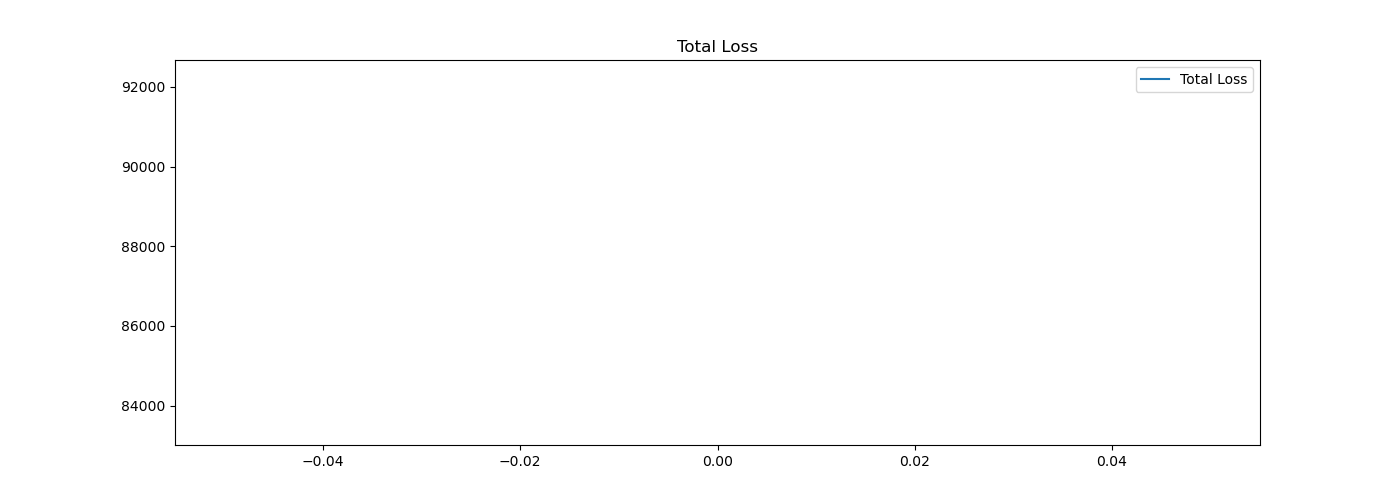

In [ ]:

plt.figure(figsize=(14, 5))
plt.plot(total_losses, label='Total Loss')
plt.legend()
plt.title('Total Loss')
plt.show()

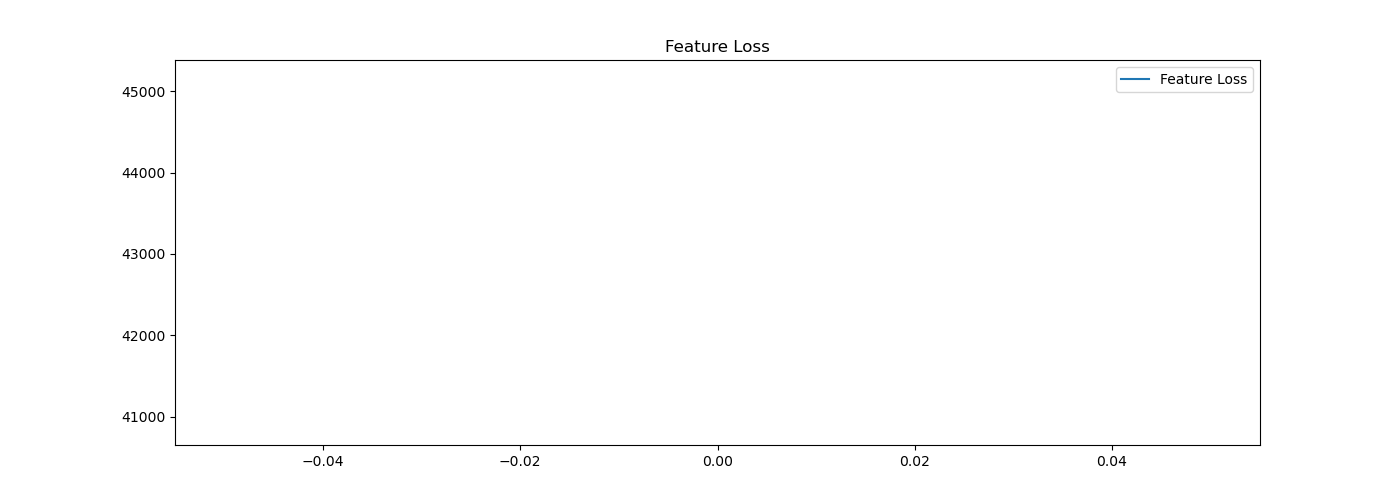

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(feature_losses, label='Feature Loss')
plt.legend()
plt.title('Feature Loss')
plt.show()

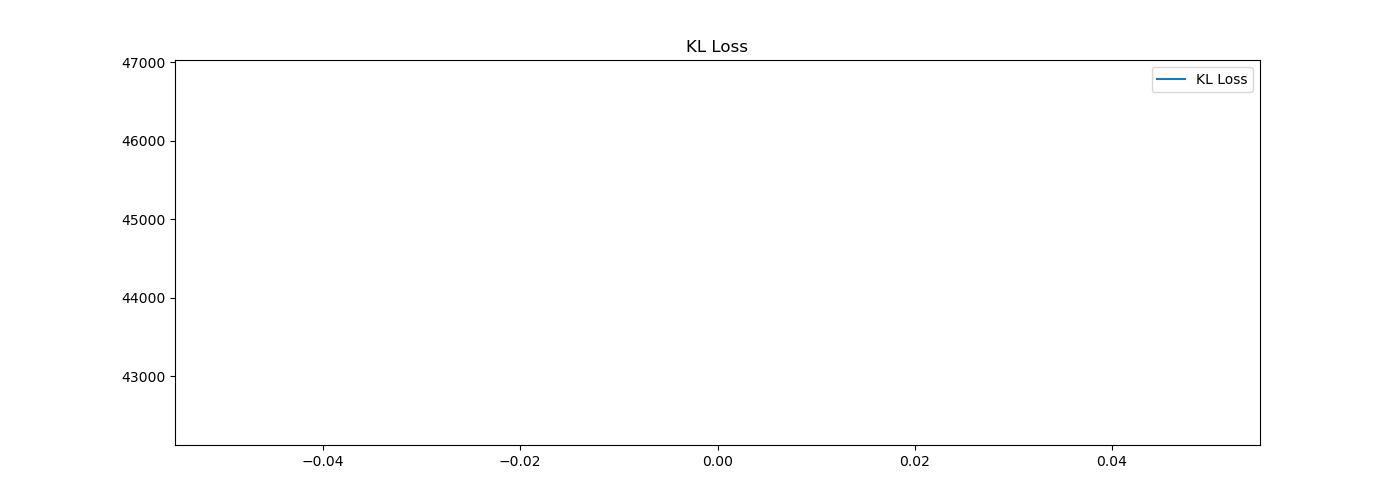

In [ ]:
plt.figure(figsize=(14, 5))
plt.plot(kl_losses, label='KL Loss')
plt.legend()
plt.title('KL Loss')
plt.show()